# Task 2 - LSTM for time series classification

In [1]:
import numpy as np
import pandas as pd
import re
import os

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

In [3]:
# GPU
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.7 GB  | Proc size: 188.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## Data import & EDA

In [4]:
files.upload()

Saving Ambient_Living_1.csv to Ambient_Living_1.csv
Saving Ambient_Living_2.csv to Ambient_Living_2.csv
Saving Ambient_Living_3.csv to Ambient_Living_3.csv
Saving Ambient_Living_4.csv to Ambient_Living_4.csv
Saving Ambient_Living_5.csv to Ambient_Living_5.csv
Saving Ambient_Living_6.csv to Ambient_Living_6.csv
Saving Ambient_Living_7.csv to Ambient_Living_7.csv
Saving Ambient_Living_8.csv to Ambient_Living_8.csv
Saving Ambient_Living_9.csv to Ambient_Living_9.csv
Saving Ambient_Living_10.csv to Ambient_Living_10.csv
Saving Ambient_Living_11.csv to Ambient_Living_11.csv
Saving Ambient_Living_12.csv to Ambient_Living_12.csv
Saving Ambient_Living_13.csv to Ambient_Living_13.csv
Saving Ambient_Living_14.csv to Ambient_Living_14.csv
Saving Ambient_Living_15.csv to Ambient_Living_15.csv
Saving Ambient_Living_16.csv to Ambient_Living_16.csv
Saving Ambient_Living_17.csv to Ambient_Living_17.csv
Saving Ambient_Living_18.csv to Ambient_Living_18.csv
Saving Ambient_Living_19.csv to Ambient_Living

{'Ambient_Living_1.csv': b'Sensor 1,Sensor 2,Sensor 3,Sensor 4\r\n-0.90476,-0.48,0.28571,0.3\r\n-0.57143,-0.32,0.14286,0.3\r\n-0.38095,-0.28,-0.14286,0.35\r\n-0.28571,-0.2,-0.47619,0.35\r\n-0.14286,-0.2,0.14286,-0.2\r\n-0.14286,-0.2,0.047619,0\r\n-0.14286,-0.16,-0.38095,0.2\r\n-0.14286,-0.04,-0.61905,-0.2\r\n-0.095238,-0.08,0.14286,-0.55\r\n-0.047619,0.04,-0.095238,0.05\r\n-0.19048,-0.04,0.095238,0.4\r\n-0.095238,-0.04,-0.14286,0.35\r\n-0.33333,-0.08,-0.28571,-0.2\r\n-0.2381,0.04,0.14286,0.35\r\n0,0.08,0.14286,0.05\r\n-0.095238,0.04,0.095238,0.1\r\n-0.14286,-0.2,0.14286,0.5\r\n-0.19048,0.04,-0.42857,0.3\r\n-0.14286,-0.08,-0.2381,0.15\r\n-0.33333,0.16,-0.14286,-0.8\r\n-0.42857,0.16,-0.28571,-0.1\r\n-0.71429,0.16,-0.28571,0.2\r\n-0.095238,-0.08,0.095238,0.35\r\n-0.28571,0.04,0.14286,0.2\r\n0,0.04,0.14286,0.1\r\n0,0.04,-0.047619,-0.05\r\n-0.14286,-0.6,-0.28571,-0.1',
 'Ambient_Living_10.csv': b'Sensor 1,Sensor 2,Sensor 3,Sensor 4\r\n-0.42857,-0.56,-0.66667,0.35\r\n-0.28571,-0.48,0.19048,-

In [5]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'(?P<seq_id>\d+).csv'
data_files = list(filter(lambda s: re.match(data_file_pattern, s) is not None, os.listdir()))
N_FILES = len(data_files)
N_FILES

216

In [6]:
seq_ids = sorted(int(re.match(data_file_pattern, file_name).group('seq_id')) for file_name in data_files)
print(seq_ids)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]


In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [8]:
seq_id = seq_ids[0]
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [9]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,27.000000,27.000000,27.000000,27.000000
mean,-0.232805,-0.082963,-0.077601,0.088889
std,0.216344,0.185614,0.240700,0.299465
min,-0.904760,-0.600000,-0.619050,-0.800000
25%,-0.309520,-0.200000,-0.285710,-0.075000
50%,-0.142860,-0.040000,-0.047619,0.150000
75%,-0.095238,0.040000,0.142860,0.325000
max,0.000000,0.160000,0.285710,0.500000


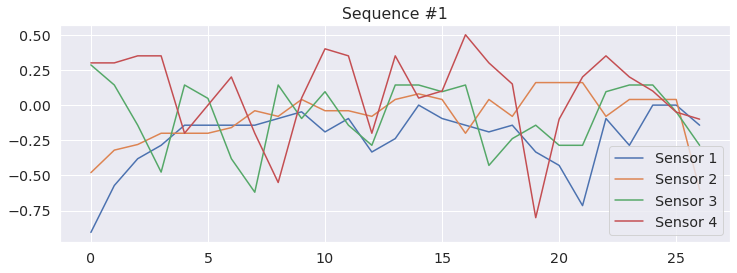

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [11]:
# load targets (class labels) for available sequences (only those which have been uploaded)
targets = load_file('target', True).iloc[np.array(seq_ids)-1]
targets.head()

,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [12]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    111
 1    105
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
# load data for the available sequences
all_data = [load_file(i) for i in seq_ids]


In [15]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data]
descr['n_features'] = [d.shape[1] for d in all_data]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
1,1,27,4
2,1,26,4
3,1,23,4
4,1,23,4
5,1,25,4


In [16]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,216.000000,216.0
mean,37.407407,4.0
std,14.948306,0.0
min,19.000000,4.0
20%,24.000000,4.0
40%,27.000000,4.0
50%,33.500000,4.0
60%,40.000000,4.0
80%,54.000000,4.0
max,103.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [17]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

54

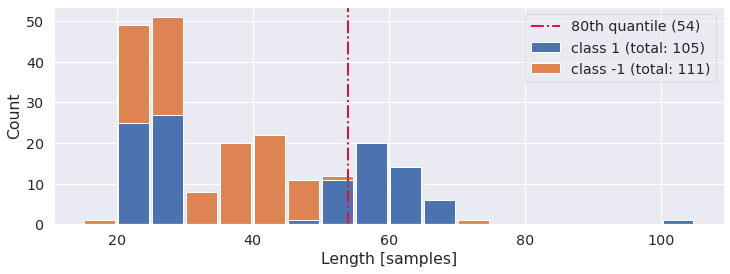

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[0].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

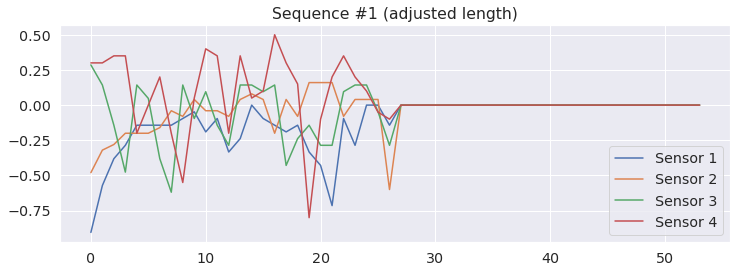

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm(my_lstm_units, my_lr):
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(my_lstm_units, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=my_lr)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=100, batch_size=N_FILES//6)
sk_params = dict(**fit_params, my_lstm_units=256, my_lr=0.001)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
kc = KerasClassifier(make_lstm, **sk_params)


In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


In [0]:
# run the cross-validation
# scores = cross_val_score(KerasClassifier(make_lstm, **sk_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


In [0]:
# scores

## Grid search

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {'my_lr': [0.001, 0.01, 0.1], 'batch_size': [N_FILES, N_FILES//3, N_FILES//6], 'my_lstm_units': [128, 256]}

In [29]:
gcv = GridSearchCV(KerasClassifier(make_lstm, **fit_params), param_grid=param_grid, cv=kf, scoring=scorer)
gcv

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc27e90f0f0>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [216, 72, 36],
                         'my_lr': [0.001, 0.01, 0.1],
                         'my_lstm_units': [128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc27e90a7b8>, verbose=0)

In [30]:
gcv.fit(all_data_prep, all_labels)

Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 0s 7ms/step - loss: 0.7366 - accuracy: 0.4205
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6577 - accuracy: 0.5795
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6675 - accuracy: 0.6308
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6569 - accuracy: 0.6974
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5884 - accuracy: 0.7436
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5259 - accuracy: 0.7538
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5435 - accuracy: 0.7385
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5107 - accuracy: 0.7282
Epoch 9/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5379 - accuracy: 0.7026
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5292 - accurac

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc27e90f0f0>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [216, 72, 36],
                         'my_lr': [0.001, 0.01, 0.1],
                         'my_lstm_units': [128, 256]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=<function scorer at 0x7fc27e90a7b8>, verbose=0)

In [31]:
gcv.best_params_

{'batch_size': 72, 'my_lr': 0.001, 'my_lstm_units': 128}

In [32]:
gcv.best_score_

0.9584415584415584

In [33]:
gcv.cv_results_

{'mean_fit_time': array([4.07820044, 4.17592611, 3.87950776, 4.17449455, 3.92226031,
        4.22422419, 5.13381326, 5.45777943, 5.14581318, 5.47293081,
        5.16140029, 5.38096759, 6.89132562, 7.48554749, 6.86290021,
        7.32743137, 7.0370219 , 7.47898858]),
 'mean_score_time': array([0.44626544, 0.42404065, 0.45548704, 0.422157  , 0.45993624,
        0.41733611, 0.4154794 , 0.42212265, 0.48555982, 0.4141659 ,
        0.40986021, 0.41638048, 0.4164829 , 0.41364202, 0.41025181,
        0.50667605, 0.409762  , 0.42236822]),
 'mean_test_score': array([0.8978355 , 0.89761905, 0.77164502, 0.7021645 , 0.61406926,
        0.60324675, 0.95844156, 0.89199134, 0.88787879, 0.73138528,
        0.63333333, 0.60735931, 0.92099567, 0.93982684, 0.81948052,
        0.72012987, 0.59242424, 0.56320346]),
 'param_batch_size': masked_array(data=[216, 216, 216, 216, 216, 216, 72, 72, 72, 72, 72, 72,
                    36, 36, 36, 36, 36, 36],
              mask=[False, False, False, False, False, F

In [34]:
gcv.cv_results_['mean_test_score']

array([0.8978355 , 0.89761905, 0.77164502, 0.7021645 , 0.61406926,
       0.60324675, 0.95844156, 0.89199134, 0.88787879, 0.73138528,
       0.63333333, 0.60735931, 0.92099567, 0.93982684, 0.81948052,
       0.72012987, 0.59242424, 0.56320346])

In [0]:
cvr = gcv.cv_results_

In [0]:
codes = ['my_lr', 'batch_size', 'my_lstm_units']


Text(0.5, 0, 'my_lstm_units')

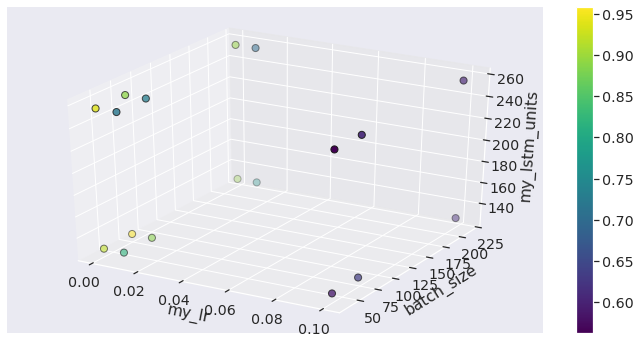

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(*tuple(cvr[f'param_{code}'].data.astype(float) for code in codes),
               c=cvr['mean_test_score'], marker='o', s=50, cmap='viridis', edgecolor='k')
fig.colorbar(p, ax=ax)

ax.set_xlabel(codes[0])
ax.set_ylabel(codes[1])
ax.set_zlabel(codes[2])